In [2]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from collections import OrderedDict
from pygsp import graphs, filters, plotting
from IPython.display import Image

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [3]:
dataset = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [4]:
dataset.head(3)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,actor_names,actors_ids,actors_tenures,total_tenure,average_tenure,Metacritic,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.2,90,2.639,4
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.6,61,2.127,3
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.0,63,2.639,4


In [5]:
dataset['Profitability'] = dataset['revenue']-dataset['budget']

In [6]:
dataset.head(3)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,actor_names,actors_ids,actors_tenures,total_tenure,average_tenure,Metacritic,ROI,success,Profitability
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.2,90,2.639,4,846335536
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.6,61,2.127,3,27231879
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.0,63,2.639,4,515011224


## Data exploration ###

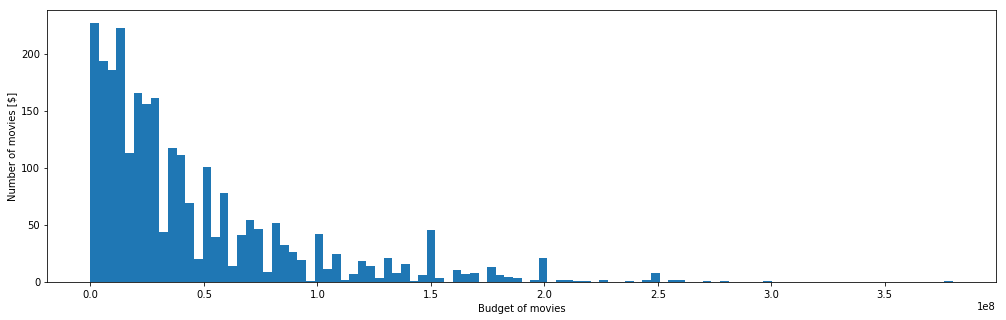

In [23]:
plt.hist(dataset['budget'],bins=100);
plt.xlabel('Budget of movies')
plt.ylabel('Number of movies [$]')
plt.savefig('images/movies_budget.png', dpi=300, bbox_inches='tight')

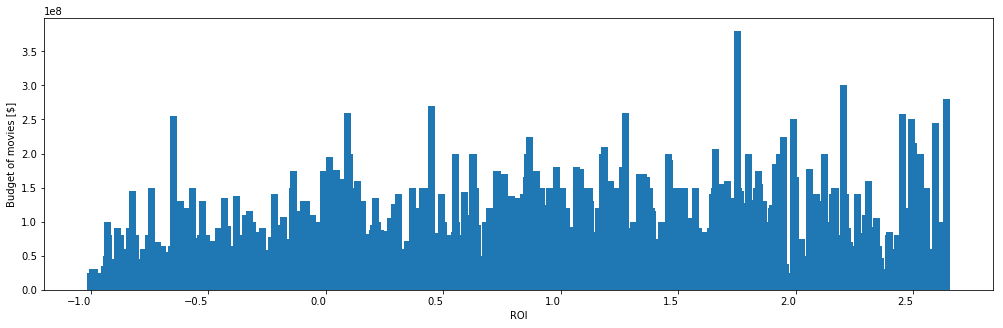

In [18]:
plt.bar(dataset['ROI'],dataset['budget'], align='center',width=0.03);
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='right');
plt.xlabel('ROI');
plt.ylabel('Budget of movies [$]');
plt.savefig('images/budget_ROI.png', dpi=300, bbox_inches='tight')

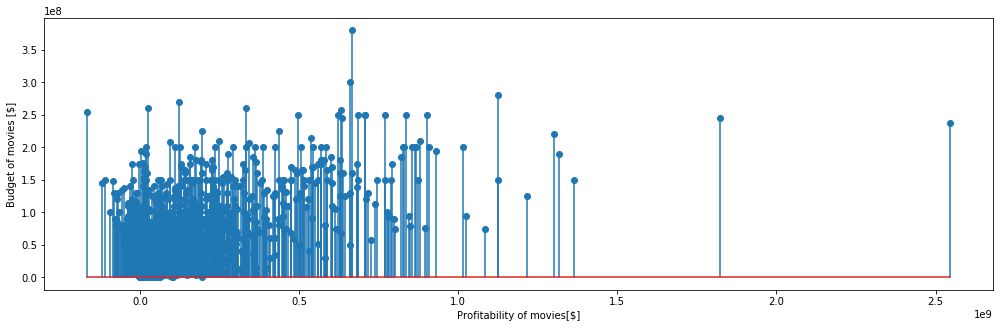

In [20]:
#print(profi)
#print(bud)
plt.stem(dataset['Profitability'], dataset['budget']);
#plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='right');
#plt.xlabel('ROI');
#plt.ylabel('Budget of movies');
plt.xlabel('Profitability of movies[$]')
plt.ylabel('Budget of movies [$]')
plt.savefig('images/budget_Profitability.png', dpi=300, bbox_inches='tight')

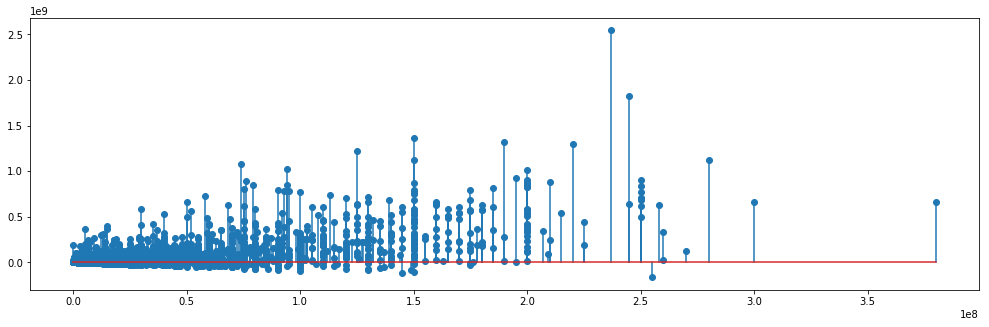

In [15]:
plt.stem(dataset['budget'],dataset['Profitability']);

In [16]:
min(dataset['budget'])

1000

In [12]:
#min(dataset['budget'])
print(min(test))
print(min(prof))

1000
-165710090


In [ ]:
plt.bar(tt,vv)

In [ ]:
dataset['budget'][:]

## Difference of budget between movies ##

In [ ]:
#W = np.ndarray(shape=(10, 10), dtype=int)
W_diff = np.zeros(shape=(len(dataset), len(dataset)), dtype=int)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        W_diff[i][j] = abs(dataset['budget'][i]-dataset['budget'][j])

In [ ]:
plt.spy(W_diff)

In [ ]:
bigger = W_diff.transpose() > W_diff
W_diff = W_diff - W_diff*bigger + W_diff.transpose()*bigger
np.fill_diagonal(W_diff, 0)

In [ ]:
plt.hist(W_diff.reshape(-1),bins=50);

### Weights Normalization ###

In [ ]:
val_75 = np.percentile(W_diff,75)
print(val_75)

In [ ]:
W_diff_norm = np.zeros(shape=(len(dataset), len(dataset)), dtype=float)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        if W_diff[i][j] == 0:
            W_diff_norm[i][j] = 1
        elif W_diff[i][j] <= val_75:  
            W_diff_norm[i][j] = 1-(W_diff[i][j])/(val_75)
        else:
            W_diff_norm[i][j] = 0

In [ ]:
max_W_diff = W_diff.max()
W_diff_norm = np.zeros(shape=(len(dataset), len(dataset)), dtype=float)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        if W_diff[i][j] == 0:
            W_diff_norm[i][j] = 1
        else:  
            W_diff_norm[i][j] = 1-(W_diff[i][j])/(max_W_diff)

In [ ]:
bigger = W_diff_norm.transpose() > W_diff_norm
W_diff_norm = W_diff_norm - W_diff_norm*bigger + W_diff_norm.transpose()*bigger
np.fill_diagonal(W_diff_norm, 0)

In [ ]:
plt.spy(W_diff_norm)

In [ ]:
DiffNormW = pd.DataFrame(W_diff_norm)
DiffNormW.head()

In [ ]:
plt.hist(W_diff_norm.reshape(-1),bins=50);

In [ ]:
#Compute degree distribution 
degrees = np.zeros(len(W_diff_norm)) 
for i in range(0, len(W_diff_norm)):
    degrees[i] = sum(W_diff_norm[i])

plt.hist(degrees, bins=50);

In [ ]:
DiffNormW.to_csv('Saved_Datasets/DiffNormBudgW.csv', index=False)

In [ ]:
G = graphs.Graph(W_diff_norm)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

In [ ]:
labels = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])

In [ ]:
G.plot_signal(labels, vertex_size=20)

### Weight matrix sparsification 

In [ ]:
NEIGHBORS = 300

#sort the order of the weights
sort_order = np.argsort(W_diff_norm, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(W_diff_norm), len(W_diff_norm)))

for i in range (0, len(W_diff_norm)):  
    for j in range(0, len(W_diff_norm)):
        if (j >= len(W_diff_norm) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = W_diff_norm[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

In [ ]:
plt.spy(sorted_weights)

In [ ]:
DiffSparsW = pd.DataFrame(sorted_weights)
DiffSparsW.head()

In [ ]:
DiffSparsW.to_csv('Saved_Datasets/DiffNormSparsBudgW.csv', index=False)

In [ ]:
G = graphs.Graph(sorted_weights)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

In [ ]:
labels = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])

In [ ]:
G.plot_signal(labels, vertex_size=20)